# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY


hexagons                                           geometry     lon  \
0  8755a9072ffffff  POLYGON ((20.82908 -15.41801, 20.81905 -15.427... 20.8169   
1  87399cb2cffffff  POLYGON ((30.55992 -8.55845, 30.55033 -8.56925... 30.5470   
2  8739a6783ffffff  POLYGON ((33.85755 -12.11658, 33.84759 -12.127... 33.8445   
3  87551aa8effffff  POLYGON ((21.18746 -14.04919, 21.17752 -14.058... 21.1753   
4  8739842e5ffffff  POLYGON ((32.65780 -9.62459, 32.64811 -9.63562... 32.6448   

       lat  
0 -15.4135  
1  -8.5547  
2 -12.1120  
3 -14.0449  
4  -9.6205

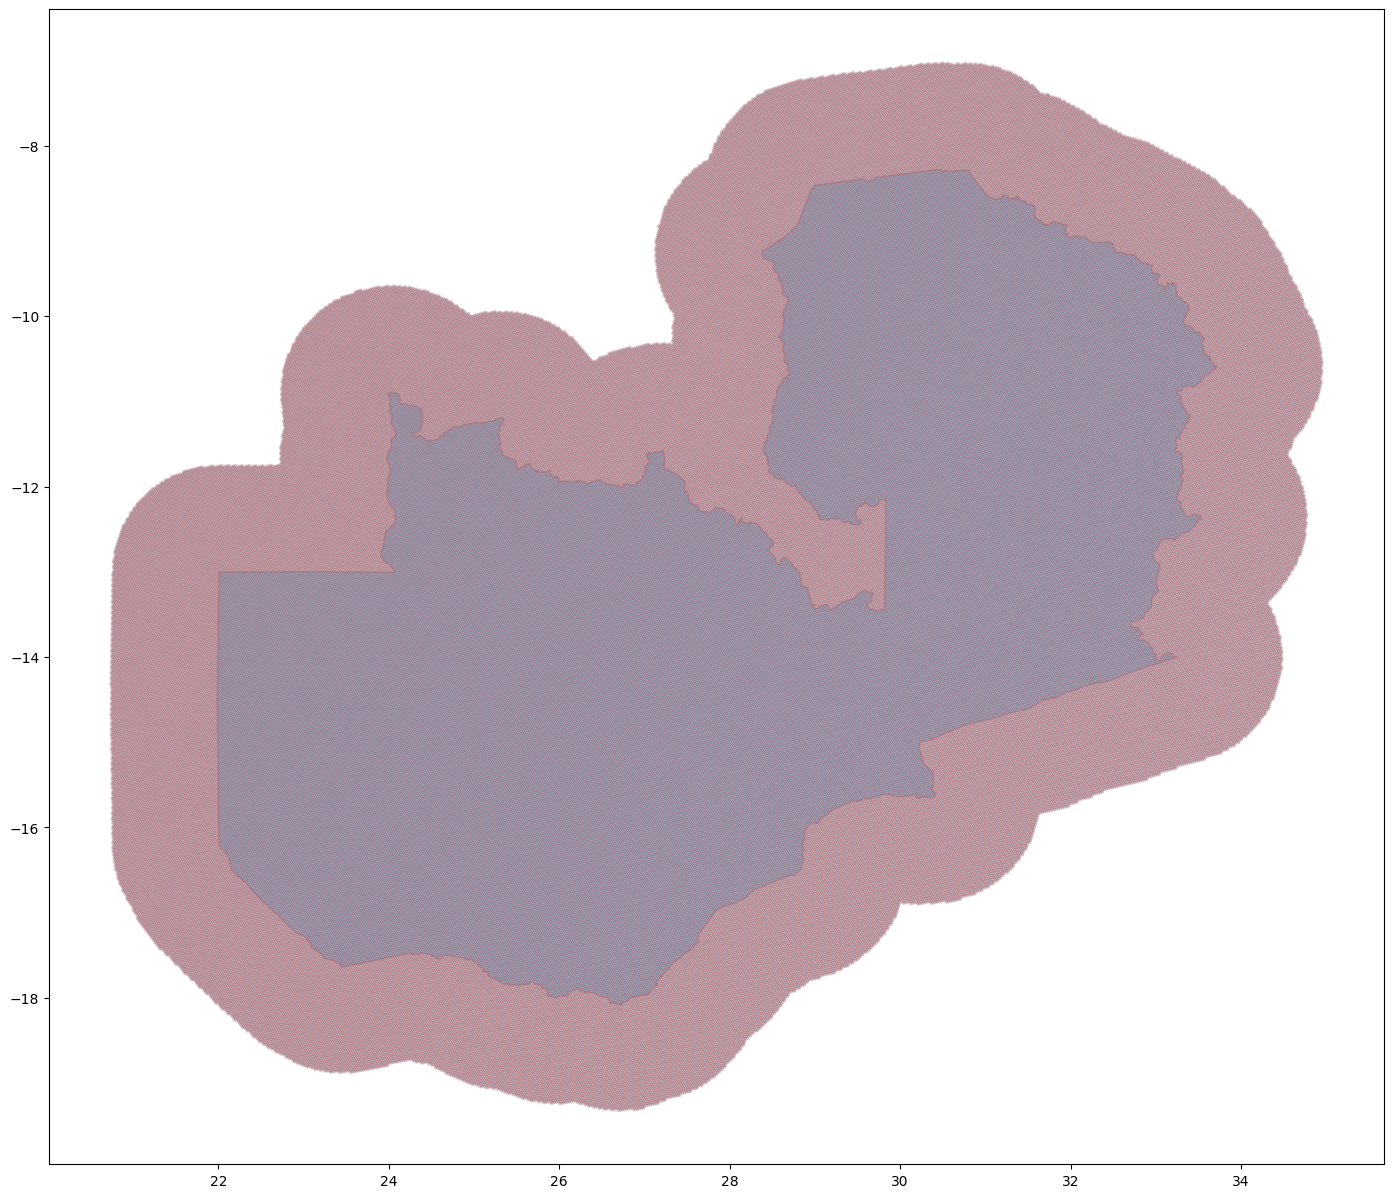

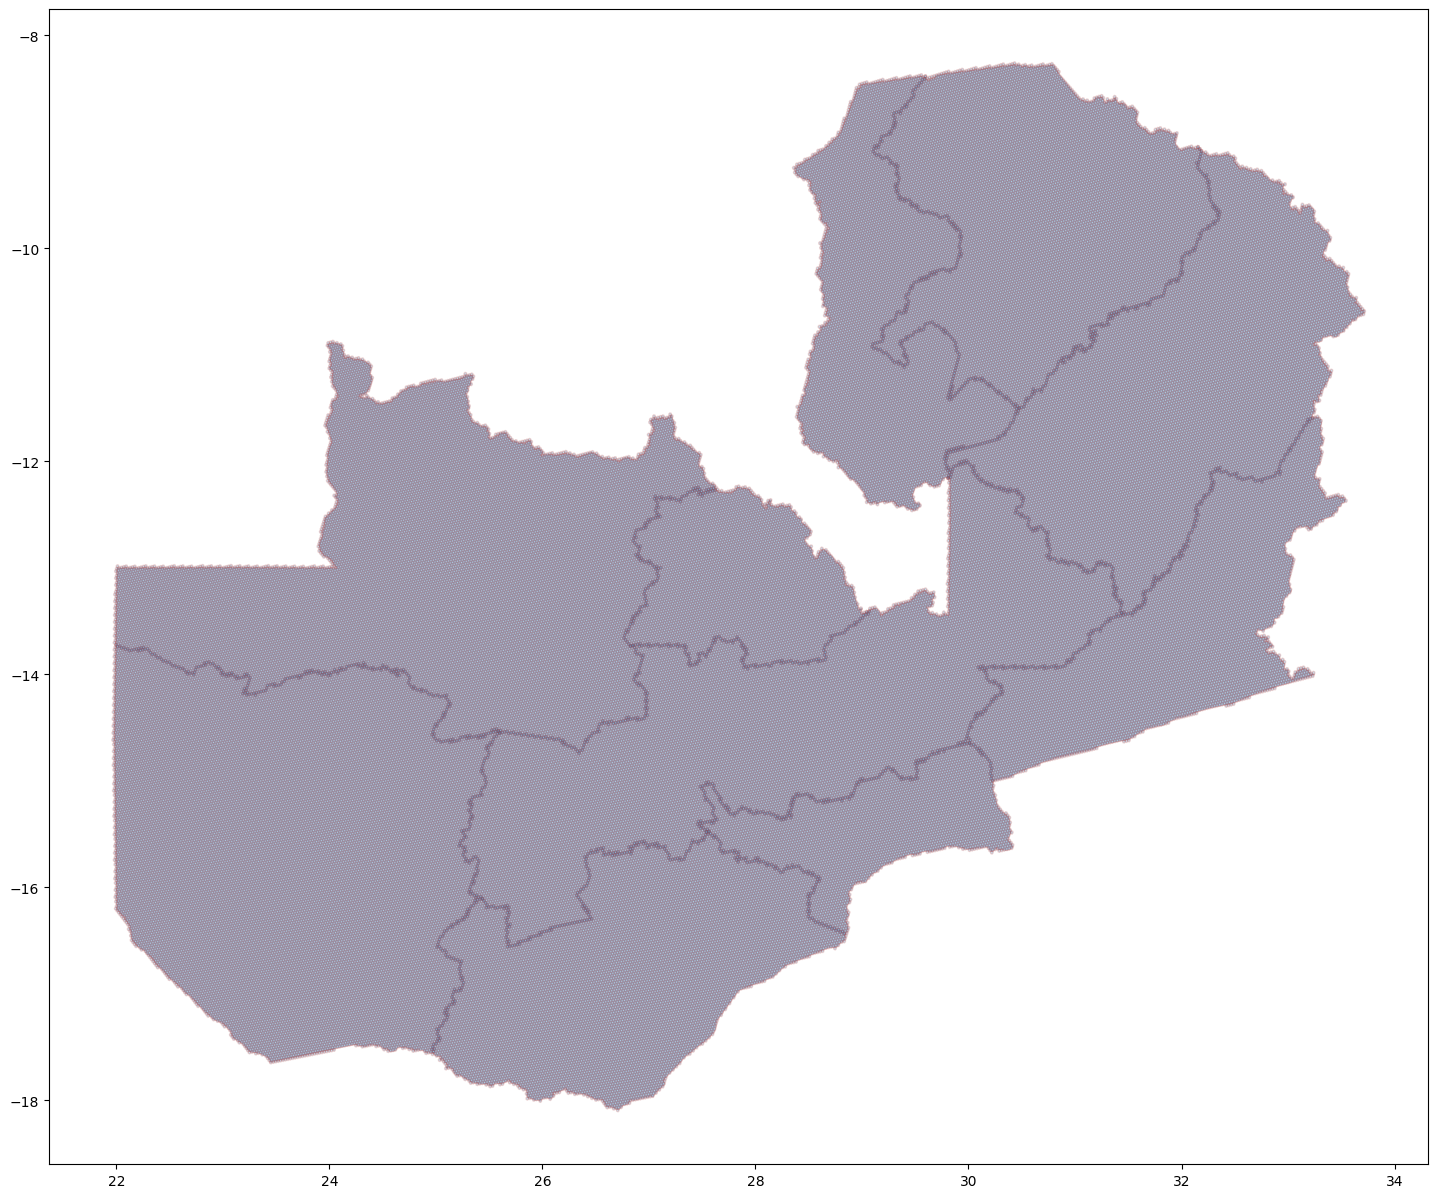

In [7]:
%run BaseGrid.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [8]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [9]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

In [ ]:
%run Residential/BuildingDemandMethod1_Simplified.ipynb
total_residentialenergy_assessed = grid["REnS_kWh"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

In [ ]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [ ]:
%run Industry/IndustryDemand.ipynb
print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

In [ ]:
#Concatenate results
gridRes = gpd.read_file(out_path + "\\" + "res_energy_map.shp")
# gridRes = gridRes.to_crs(crs_proj)
gridInd = gpd.read_file(out_path + "\\" + "ind_energy_map.shp")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridRes.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

In [ ]:
#Unit
grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
total_ind = grid["IndEnergy_GWh"].sum()
print(total_ind)
grid['REnS_GWh'] = grid['REnS_kWh']/10**6
total_res = grid["REnS_GWh"].sum()
print(total_res)
grid['SEn_GWh'] = grid['SEn_kWh']/10**6
total_ser = grid["SEn_GWh"].sum()
print(total_ser)

In [ ]:
grid["TotalDem"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                             row["IndEnergy_GWh"]
                                                     ])), axis=1) #sum in GWh

In [ ]:
total = grid["TotalDem"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

In [ ]:
grid.head(3)

### Export result

In [ ]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [ ]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

In [ ]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')